In [1]:
from data_loader.data_loaders import get_loader, MnistDataLoader
import os
import matplotlib.pyplot as plt
from model.model import *
import torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary as summary
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from model import loss
import model.model as module_model
import model.loss as module_loss
import model.metric as module_metric
import logger
from trainer import Trainer
from torch.optim import lr_scheduler
from monai.losses import MaskedDiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNet, RegUNet, AttentionUnet

ModuleNotFoundError: No module named 'torchsummary'

In [2]:
train_data_loader = get_loader(os.getcwd()+'/data/plant', batch_size=10, mode='train') # binary dataset
valid_data_loader = get_loader(os.getcwd()+'/data/plant', batch_size=10, mode='valid')

/home/hklee/workspace/torch-project/data/plant/images/train /home/hklee/workspace/torch-project/data/plant/masks/train
/home/hklee/workspace/torch-project/data/plant/images/valid /home/hklee/workspace/torch-project/data/plant/masks/valid


In [3]:
for img ,mask in train_data_loader:
    print(img.shape)
    print(img.dtype)
    print(mask.shape)
    print(mask.dtype)
    break

torch.Size([10, 3, 240, 240])
torch.float32
torch.Size([10, 1, 240, 240])
torch.float32


model.py -> BaseModel 상속으로 바꾸고 학습되는지 보기

In [4]:
# model = UNET2().to(device)
# summary(model, (3, 240, 240))		  
model = AttentionUnet(
    spatial_dims= 2,
    in_channels=3,
    out_channels=1,
    channels=[64,128,256,512],
    strides=[1,1,1]
).to(device)

In [5]:
model = module_model.AttU_Net().to(device)

In [6]:
# model = module_model.MonaiAttentionUnet().to(device)

In [7]:
# init
EPOCHS = 10
epoch_loss_values = list()
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = getattr(module_loss, 'bce_logitloss')
optimizer = optim.Adam(list(model.parameters()), 1e-5)
val_interval = 5

In [8]:
for epoch in range(EPOCHS, EPOCHS+20):
    epoch_loss = 0.0
    
    model.train() # switch to train mode
    for step, batch in enumerate(tqdm(train_data_loader)):
        inputs, labels = batch
        # inputs = inputs.type('torch.FloatTensor')
        # labels = labels.type('torch.FloatTensor')
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device) 

        # forward + backward + optimizer 최적화
        outputs = model(inputs)
        loss = criterion(outputs, labels) # loss 계산
        
        optimizer.zero_grad() # gradient(변화도) 0으로 만들고
        loss.backward() # 역전파
        optimizer.step()

        epoch_loss += loss.item()
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0 :
        model.eval()
        with torch.no_grad():
            print('check interval!')
        
print("finished")


100%|██████████| 11/11 [00:03<00:00,  2.81it/s]


epoch 1 average loss: -27.5442


100%|██████████| 11/11 [00:02<00:00,  4.82it/s]


epoch 2 average loss: -73.0732


100%|██████████| 11/11 [00:02<00:00,  4.74it/s]


epoch 3 average loss: -106.1514


100%|██████████| 11/11 [00:02<00:00,  4.77it/s]


epoch 4 average loss: -127.8243


100%|██████████| 11/11 [00:02<00:00,  4.54it/s]


epoch 5 average loss: -141.4711
check interval!


100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


epoch 6 average loss: -153.0414


100%|██████████| 11/11 [00:02<00:00,  4.80it/s]


epoch 7 average loss: -159.0770


 18%|█▊        | 2/11 [00:00<00:02,  3.74it/s]

### Trainer
```
trainer init
    def __init__(self, model, criterion, metric_ftns, optimizer, config, device,
                 data_loader, valid_data_loader=None, lr_scheduler=None, len_epoch=None):
        super().__init__(model, criterion, metric_ftns, optimizer, config)
```

In [16]:
# init
EPOCHS = 30
epoch_loss_values = list()
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = DiceLoss()
optimizer = optim.Adam(list(model.parameters()), 1e-5)
val_interval = 5
metrics = [getattr(module_metric, 'dice')]

In [17]:
# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
lr_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch : 0.95**epoch)

trainer = Trainer(model, criterion, metrics, optimizer,
                    config=config,
                    device=device,
                    data_loader=train_data_loader,
                    valid_data_loader=valid_data_loader,
                    lr_scheduler=lr_scheduler)

trainer.train()


NameError: name 'config' is not defined

### Inference

In [11]:
test_loader = get_loader('./data/plant', mode='test', batch_size=10)
for i in test_loader:
    print(i[0].shape)
    break

./data/plant/images/test ./data/plant/masks/test
torch.Size([10, 3, 240, 240])


In [12]:
for img, mask in test_loader:
    img = img.to(device)
    outputs = model(img)
    break

In [13]:
outputs = outputs.to('cpu')
outputs = torch.sigmoid(outputs)
outputs = (outputs > 0.5).float()

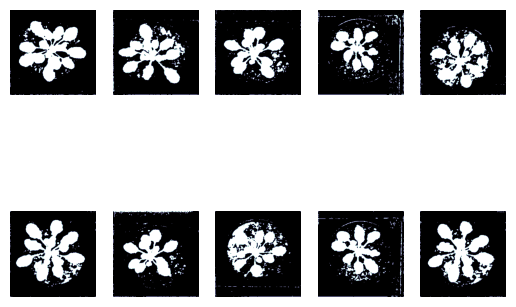

In [14]:
numpy_outputs = outputs.to('cpu').detach().numpy()
for i in range(10):
    plt.subplot(2, 5, i+1)
    result = outputs[i, :, :, :].squeeze()
    plt.imshow(result, cmap='bone')
    plt.axis('off')
    
plt.show()

In [15]:
file_name = 'monai_unet_epoch30_loss(Dice).png'
torchvision.utils.save_image(outputs, f'./saved/{file_name}', nrow=5)

: 

In [ ]:
img = img.to('cpu')
img = img.detach().numpy()

In [ ]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    result = img[i, :, :, :].squeeze()
    result = result.transpose(1,2,0)
    plt.imshow(result, cmap='bone')
    plt.axis('off')
    
plt.show()


In [ ]:
mask = mask.to('cpu').detach().numpy()
for i in range(10):
    plt.subplot(2, 5, i+1)
    result = mask[i, :, :].squeeze()
    # result = result.transpose(1,2,0)
    plt.imshow(result, cmap='bone')
    plt.axis('off')
    
plt.show()

# Monai Test

In [4]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNet, RegUNet, AttentionUnet

model = UNet(
    spatial_dims= 2,
    in_channels=3,
    out_channels=1,
    channels=[64,128,256,512],
    strides=[1,1,1]
)

In [ ]:
model = SwinUNETR(
        img_size=(96, 96, 96),
        in_channels=3,
        out_channels=4,
        feature_size=48
    )

In [12]:
a = np.zeros(shape=(240,240))

In [23]:
t = torch.tensor(a)
t.shape
t = torch.unsqueeze(t, 0)
t.shape

torch.Size([1, 240, 240])

In [ ]:
model.to(device)

In [ ]:
summary(model, (3, 240, 240))